In [1]:
#@title
%%capture
!pip install swig
!pip install gymnasium[box2d]
!pip install renderlab

In [2]:
#@title
%%capture

import gymnasium as gym
import renderlab as rl
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
from IPython.display import clear_output

  if event.key is 'enter':



In [3]:
class Net():
  def __init__(self, chromosome):
    # 8 => 10 => 4
    self.w1 = chromosome[:80].reshape((10,8))
    self.b1 = chromosome[80:90].reshape((10,))
    self.w2 = chromosome[90:130].reshape((4,10))
    self.b2 = chromosome[130:].reshape((4,))
  def forward(self, x):
    s1 = np.dot(self.w1, x) + self.b1
    z1 = s1 * (s1 > 0.0)
    s2 = np.dot(self.w2, z1) + self.b2
    z2 = s2 * (s2 > 0.0)
    return z2.argmax()

In [4]:
def create_individual():
  ''' Esta função cria o genótipo de um indivíduo
      completamente aleatório
  '''
  N = 8*10+10+10*4+4
  chromosome = np.random.normal(0, 10, size=(N,))
  return chromosome, None

In [5]:
def create_population(size):
  ''' Aqui geramos uma população inteira
  '''
  # Nossa população será uma lista
  population = list()
  # Nesse laço criamos cada indivíduo
  # e adicionamos à população
  for _ in range(size):
    population.append(create_individual())
  return population

In [6]:
def get_phenotype(chromosome):
  ''' Esta função gera a imagem a partir do
      gene.
  '''
  n = Net(chromosome)
  return n

In [7]:
def fitness(n):
  R = 0.0
  trials = 6
  env = gym.make('LunarLander-v3')
  for _ in range(trials):
    obs, _ = env.reset()
    while True:
      action = n.forward(obs)
      obs, reward, term, trunc, info = env.step(action)
      R += reward
      if term or trunc:
        break
  env.close()
  return (10000.0 + R/trials) / 10000.0

In [8]:
def crossover2point(chr1, chr2):
  ''' Esta função combina os genes de
      dois indivíduos, gerando um novo
      cromossomo
  '''
  N = len(chr1)
  idx1 = np.random.randint(0,N)
  idx2 = np.random.randint(0,N)
  if idx1 > idx2:
    idx1, idx2 = idx2, idx1
  new_chr1 = np.concatenate((chr1[0:idx1], chr2[idx1:idx2], chr1[idx2:]))
  new_chr2 = np.concatenate((chr2[0:idx1], chr1[idx1:idx2], chr2[idx2:]))
  return new_chr1, new_chr2

In [9]:
def mutation(chr, p):
  ''' Esta função aplica a mutação em um dos
      genes de nosso cromossomo
  '''
  N = len(chr)
  total = int(np.random.normal(p*N, p*N))
  if total < 0:
    total = 0
  elif total > N:
    total = N
  for _ in range(total):
    idx = np.random.randint(0, N)
    if np.random.rand() > 0.5:
      chr[idx] += np.random.normal(0, 1)
    else:
      chr[idx] = np.random.normal(0, 10)
  return chr

In [10]:
def compute_fitness(population):
  ''' Esta função avalia cada indivíduo
      e adiciona o seu score.
  '''
  scored = list()
  for chromosome, score in population:
    n = get_phenotype(chromosome)
    score = fitness(n)
    scored.append((chromosome, score))
  scored.sort(key=lambda x:x[1], reverse=True)
  return scored

In [11]:
def roulette(population):
  fitnesses = np.array([np.exp(fitness) \
                       for _, fitness in population])
  total = np.sum(fitnesses)
  fitnesses /= total
  choice = np.random.rand()
  subtotal = 0
  idx = 0
  for f in fitnesses:
    subtotal += f
    if subtotal >= choice or idx == len(fitnesses)-1:
      break
    idx += 1
  return idx

In [12]:
def new_generation(population, size, mutation_rate):
  new_population = list()
  while len(new_population) < size:
    idx1 = roulette(population)
    idx2 = roulette(population)
    if idx1 == idx2:
      continue
    chr1, _ = population[idx1]
    chr2, _ = population[idx2]
    new_chr1, new_chr2 = crossover2point(chr1, chr2)
    new_chr1 = mutation(new_chr1, mutation_rate)
    new_chr2 = mutation(new_chr2, mutation_rate)
    new_population.append((new_chr1, None))
    new_population.append((new_chr2, None))
  return new_population[:size]

In [13]:
def genalg(pop_size, elite_size, \
           epochs, mutation_rate):
  x = list()
  y = list()

  population = create_population(pop_size)

  for generation in range(epochs+1):

    population = compute_fitness(population)

    chr, fit = population[0]
    _, worst = population[-1]
    n = get_phenotype(chr)
    y.append(fit)
    x.append(generation)

    if generation % 5 == 0:
      R = 0.0
      env1 = gym.make('LunarLander-v3', render_mode = 'rgb_array')
      env2 = rl.RenderFrame(env1, './output')
      obs, _ = env2.reset()
      while True:
        action = n.forward(obs)
        obs, reward, term, trunc, info = env2.step(action)
        R += reward
        if term or trunc:
          break
      # env2.close()
      clear_output()

      print('Geração', generation, ', melhor:', fit, ', pior', worst)
      env2.play()

      plt.plot(x, y)
      plt.show()

    elite = population[:elite_size]
    population = new_generation(population, pop_size - elite_size,\
                                mutation_rate) + elite
  return n, x, y

Geração 10 , melhor: 0.9911842638272302 , pior 0.8769456991585949
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  77%|███████▋  | 72/93 [00:00<00:00, 269.46it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1731180942.042317.mp4, 720000 bytes wanted but 0 bytes read,at frame 92/93, at time 3.07/3.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                             

Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


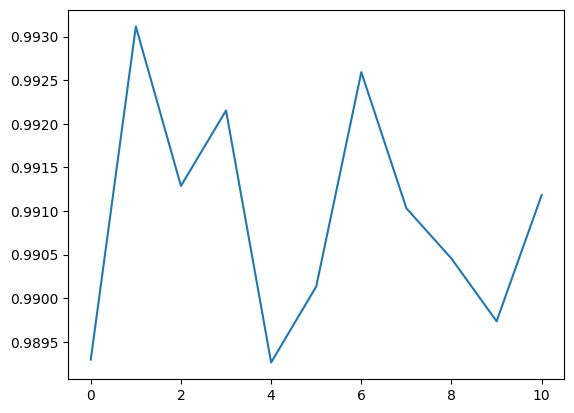

In [14]:
#n, x, y = genalg(50, 3, 1000, 0.03)
n, x, y = genalg(50, 3, 10, 0.03)

In [15]:
env = wrap_env(gym.make('LunarLander-v3'))

R = 0.0
obs = env.reset()
while True:
  action = np.random.randint(0,4)
  obs, reward, done, info = env.step(action)
  env.render()
  R += reward
  if done:
    break

print(R)

env.close()
show_video()

NameError: name 'wrap_env' is not defined